# 멋진 챗봇 만들기 :: Transfomer + Chatbot
---

Transfomer를 활용하여 한국어 챗봇을 만들어 보자 ᕕ( ᐛ )ᕗ~♪

## STEP 0. 설계
---

한국어 챗봇을 만들기 위하여 다음과 같은 순서로 프로젝트를 수행한다.
1. 데이터 수집 : 송영숙님이 공개한 챗봇 데이터를 다운로드 받는다.
2. 데이터 전처리
    - 구두점/결측치/중복 제거
    - 데이터를 질문/답변의 쌍으로 전처리 → `que_corpus` , `ans_corpus` 
     - 토큰화 : `mecab` 사용
    - Augmentation
        - 사전 훈련된 한국어 Embedding 모델을 다운로드 받아 Lexical Substitution를 적용시켜 본다.
        - Augmentation 결과를 활용하면 다음과 조합의 데이터셋이 만들어 진다.
            - 원본 que_corpus - 원본 ans_corpus
            - 원본 que_corpus - 생성된 ans_corpus 
            - 생성된 que_corpus - 원본 ans_corpus
     - 데이터 인코딩
     - ans_corpus의 양끝에 `<start>`, `<end>` 토큰을 추가 → `enc_train`, `dec_train`
3. 모델 정의
    - Positional Encoding
    - Masking
    - Multi-head Attention
    - Position-wise Feed Forward Network
    - Encoder Layer / Decoder Layer
    - Encoder / Decoder
    - Transformer
4. 모델 훈련
    - Learning Rate Scheduler 정의
    - Optimizer, Loss Funciton 정의
    - Train 함수 정의
    - 모델 훈련 수행
5. 모델 평가
    - BLEU Score를 계산하여 모델을 평가한다.

#### Environment setting

In [3]:
# import packages ########################################################
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

import re
import os
import io
import time
import random

from gensim.models import word2vec
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
print(tf.__version__)

2.4.1


In [4]:
# set directory path# #######################################################
workspace_path = os.getenv('HOME')+'/workspace/aiffel-gd-nlp/GD12_transformer_chatbot'
data_dir_path = workspace_path + '/data'

In [5]:
# initialization gpu ########################################################
import tensorflow as tf
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")
        
init_gpu()

1 Physical GPUs, 1 Logical GPUs




## Step 1. 데이터 수집
---

### 1. 한국어 챗봇 데이터 다운로드

송영숙님이 공개한 챗봇 데이터를 다운로드 받는다.

- link : https://github.com/songys/Chatbot_data

In [6]:
# ! wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv -P ./data

In [7]:
!ls ./data

ChatbotData20.csv  ko-Word2Vec.zip  s_spm_spa-eng.model
ko-Word2Vec	   lang_corpus.txt  s_spm_spa-eng.vocab


In [8]:
# !mv ./data/ChatbotData\ .csv ./data/ChatbotData20.csv

### 2. 사전 훈련된 한국어 Embedding 모델을 다운로드

사전 훈련된 한국어 Word2Vec Embedding을 아래의 링크에서 찾아 다운로드 받는다.
- link : https://github.com/Kyubyong/wordvectors

In [9]:
!ls data

ChatbotData20.csv  ko-Word2Vec.zip  s_spm_spa-eng.model
ko-Word2Vec	   lang_corpus.txt  s_spm_spa-eng.vocab


In [10]:
!unzip data/ko-Word2Vec.zip -d data/ko-Word2Vecreference

Archive:  data/ko-Word2Vec.zip
replace data/ko-Word2Vec/ko.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [11]:
!ls data/ko-Word2Vec

ko.bin	ko.tsv


## Step 2. 데이터 전처리
---

### 1. 결측치 제거 및 데이터 정제

챗봇 데이터를 읽어들여 데이터의 결측치를 제거하고, 데이터를 정제한다.<br>
데이터 정제는 다음과 같은 작업이 포함된다.
- 영문 대문자를 모두 소문자로 변환
- 영문/한글/숫자/주요 특수문자를 제외한 문자 제거

#### A. 데이터 불러오기

In [12]:
raw_data = pd.read_csv(data_dir_path + '/ChatbotData20.csv')
raw_data.head(10)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0


In [13]:
raw_data.shape

(11823, 3)

In [14]:
raw_data[raw_data['label']==0][:5]

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [15]:
raw_data[raw_data['label']==1][:5]

,Q,A,label
5290,1000일 만난 여자친구와 이별,더 오래 만날 사람 만날 거예요.,1
5291,10년 연애. 헤어졌습니다.,더 공허함이 크시겠네요.,1
5292,10년 연애사 되돌아보니 다 부질없네,더 좋은 사람 만나실 거예요.,1
5293,10년 연예의끝,더 마음이 허하겠어요.,1
5294,10년만나다 헤어지네,충분히 슬퍼하고 충분히 아파하다가 이겨내세요.,1


In [16]:
raw_data[raw_data['label']==2][:5]

,Q,A,label
8860,짝사랑만큼 고통스러운 건 없겠지.,짝사랑 만큼 감정소모가 큰 건 없을 거예요.,2
8861,1년 넘게 만났는데 지금도 불타올라,정열적인 사랑을 하고 있나봐요.,2
8862,1년 동거 중인데 계속 좋아,서로 깊게 알게되면서 더 좋아졌나봅니다.,2
8863,1년 동거하고 결혼했어,축하합니다!,2
8864,1년 만났는데도 그 사람에 대해 잘 모르겠어,더 만나보세요.,2


해당 데이터는 질문-대답-라벨의 구성을 가지며, 총 11823 쌍의 데이터가 존재한다.
데이터의 라벨은 0 : 일상다반사, 1 : 이별(부정), 2 : 사랑(긍정)으로 raw_data[raw_data['label']==0][:5]정의되어 있다.

#### B. 결측치 제거

In [17]:
raw_data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

데이터에 결측치가 없기 때문에 따로 제거할 필요가 없다.

#### C. 중복 제거

- 중복 데이터 확인

In [18]:
raw_data[raw_data['Q'].duplicated()]

,Q,A,label
196,고양이 키우고 싶어,가족들과 상의해보세요.,0
235,공시 준비 힘들어,잘 될 거예요.,0
1294,돈 벌고 싶어,많이 벌수록 좋아요.,0
1445,로또 번호 알려줘,알면 제가 하죠.,0
1481,마음이 울적해,거리를 걸어보세요.,0
...,...,...,...
11642,착해서 잘해주는 건지 좋아하는 건지,헷갈린다고 말해보세요.,2
11649,첫 눈에 반하는게 가능해?,당연히 가능하죠.,2
11658,첫사랑 생각나,지금의 사랑에 충실하세요.,2
11732,커플여행이 나을까 그냥 우리끼리 갈까?,저는 둘이 가는 게 좋아요.,2


In [19]:
raw_data[raw_data['Q'][196]==raw_data['Q']]

,Q,A,label
195,고양이 키우고 싶어,자신을 먼저 키우세요.,0
196,고양이 키우고 싶어,가족들과 상의해보세요.,0


In [20]:
raw_data[raw_data['A'].duplicated()]

,Q,A,label
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0
12,가끔 뭐하는지 궁금해,그 사람도 그럴 거예요.,0
18,가스불 켜놓고 나온거 같아,빨리 집에 돌아가서 끄고 나오세요.,0
...,...,...,...
11806,혼자만 설레고 혼자서 끝내는 짝사랑 그만할래.,맘고생 많았어요.,2
11807,화이트데이에 고백할까요?,선물을 주면서 솔직하고 당당하게 고백해보세요.,2
11809,확실히 날 좋아하는 걸 아는 남자랑 친구가 될 수 있을까?,그 사람을 위해서는 그러면 안돼요.,2
11816,회식하는데 나만 챙겨줘. 썸임?,호감이 있을 수도 있어요. 그렇지만 조금 더 상황을 지켜보세요.,2


In [21]:
raw_data[raw_data['A'][11806]==raw_data['A']]

,Q,A,label
5751,끝이났네,맘고생 많았어요.,1
6010,니가 원망스러워,맘고생 많았어요.,1
6455,방금 헤어지고 왔습니다,맘고생 많았어요.,1
7726,이제는 정말 끝,맘고생 많았어요.,1
8015,정리가 되네,맘고생 많았어요.,1
8211,진짜 끝,맘고생 많았어요.,1
8221,진짜 이제 안녕,맘고생 많았어요.,1
8234,질질 끄는연애 드디어끝이네.,맘고생 많았어요.,1
10303,썸남이 짝남 됐어요. 위로해 주세요.,맘고생 많았어요.,2
11806,혼자만 설레고 혼자서 끝내는 짝사랑 그만할래.,맘고생 많았어요.,2


- 중복 제거

In [22]:
raw_data = raw_data.drop_duplicates(['Q'])
raw_data[raw_data['Q'].duplicated()]

,Q,A,label


In [23]:
raw_data = raw_data.drop_duplicates(['A'])
raw_data[raw_data['A'].duplicated()]

,Q,A,label


In [24]:
raw_data.shape

(7731, 3)

#### D. 데이터 정제 함수 정의

In [25]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅣ가-힣?.!,]+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

#### E. 데이터 정제 및 데이터 분리

In [26]:
def get_questions_answers(raw_data):
    questions = [ preprocess_sentence(sentence) for sentence in raw_data['Q'].values ]
    answers   = [ preprocess_sentence(sentence) for sentence in raw_data['A'].values ]
    return questions, answers

In [27]:
que_corpus, ans_corpus = get_questions_answers(raw_data)

In [28]:
for q, a in zip(que_corpus[:5], ans_corpus[:5]):
    print(f'Q : {q}')
    print(f'A : {a}\n')

Q : 시 땡!
A : 하루가 또 가네요.

Q : 지망 학교 떨어졌어
A : 위로해 드립니다.

Q : 박 일 놀러가고 싶다
A : 여행은 언제나 좋죠.

Q : ppl 심하네
A : 눈살이 찌푸려지죠.

Q : sd카드 망가졌어
A : 다시 새로 사는 게 마음 편해요.



### 2. 토큰화

KoNLPy의 `mecab` 를 활용하여 토큰화를 진행하여 준다.

#### A. 문장 최대 길이 선정

👉 문장의 평균 길이
질문: 13.621653084982539
답변: 15.606260509636527

👉 문장의 최소 길이
질문: 1
답변: 1

👉 문장의 최대 길이
질문: 56
답변: 76



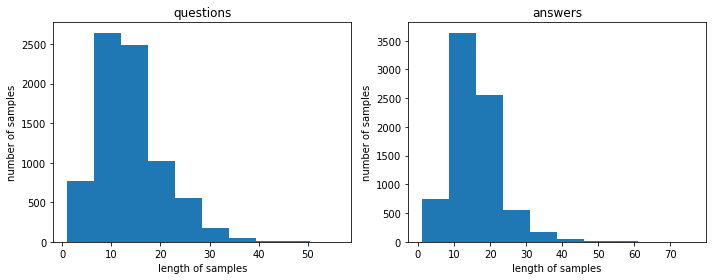

In [29]:
num_questions = np.array([len(s) for s in que_corpus])
num_answers = np.array([len(s) for s in ans_corpus])

print(f'👉 문장의 평균 길이')
print(f'질문: {np.mean(num_questions)}')
print(f'답변: {np.mean(num_answers)}\n')

print(f'👉 문장의 최소 길이')
print(f'질문: {np.min(num_questions)}')
print(f'답변: {np.min(num_answers)}\n')

print(f'👉 문장의 최대 길이')
print(f'질문: {np.max(num_questions)}')
print(f'답변: {np.max(num_answers)}\n')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.hist(num_questions)
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
ax1.set_title('questions')

ax2.hist(num_answers)
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
ax2.set_title('answers')

plt.tight_layout()
plt.show()

문장의 최대 길이는 22 정도가 적당해 보인다.

In [30]:
max_len = 22 + 2 # <start> <end> 토큰길이 포함

#### B. 토큰화 함수 정의

In [31]:
from konlpy.tag import Mecab

def tokenize(src_corpus, tgt_corpus, max_len):
    mecab = Mecab()
    src_morpheme = [ mecab.morphs(sen) for sen in src_corpus ]
    tgt_morpheme = [ mecab.morphs(sen) for sen in tgt_corpus ]
    
    combined_morpheme = [(src, tgt) for src, tgt in zip(src_morpheme, tgt_morpheme)
                          if len(src) <= max_len and len(tgt) <= max_len ]
    
    src_morpheme = [ sen for sen, _ in combined_morpheme ]
    tgt_morpheme = [ sen for _, sen in combined_morpheme ]
    
    return src_morpheme, tgt_morpheme

#### C. 토큰화

In [32]:
que_corpus_tokenized, ans_corpus_tokenized = tokenize(que_corpus, ans_corpus, max_len)

In [33]:
for q, a in zip(que_corpus_tokenized[:5], ans_corpus_tokenized[:5]):
    print(f'Q : {q}')
    print(f'A : {a}\n')

Q : ['시', '땡', '!']
A : ['하루', '가', '또', '가', '네요', '.']

Q : ['지망', '학교', '떨어졌', '어']
A : ['위로', '해', '드립니다', '.']

Q : ['박', '일', '놀', '러', '가', '고', '싶', '다']
A : ['여행', '은', '언제나', '좋', '죠', '.']

Q : ['ppl', '심하', '네']
A : ['눈살', '이', '찌푸려', '지', '죠', '.']

Q : ['sd', '카드', '망가졌', '어']
A : ['다시', '새로', '사', '는', '게', '마음', '편해요', '.']



### 3. Augmentation

#### A. Word2Vec 모델 불러오기

In [34]:
word2vec_path = data_dir_path + '/ko-Word2Vec/ko.bin'
wv = word2vec.Word2Vec.load(word2vec_path)

- 테스트

In [36]:
for sample_tokens in ans_corpus_tokenized[:3]:
    selected_tok = random.choice(sample_tokens)

    result = [ wv.wv.most_similar(tok)[0][0] if tok is selected_tok else tok for tok in sample_tokens ]
    print(f'from : {" ".join(sample_tokens)}')
    print(f'to   : {" ".join(result)}\n')

from : 하루 가 또 가 네요 .
to   : 하루 가 또 가 군요 .

from : 위로 해 드립니다 .
to   : 위로 해 드립니다 는데

from : 여행 은 언제나 좋 죠 .
to   : 여행 은 언제나 좋 죠 는데



#### B. Lexical Substitution

In [37]:
def lexical_sub(sentence_arr, wv):
    try:
        i = np.random.randint(len(a))
        res = sentence_arr[::]
        res[i] = wv.most_similar(sentence_arr[i])[0][0]

    except:   # 단어장에 없는 단어
        return None

    return res

In [38]:
def augment_corpus(src_corpus, tgt_corpus, wv):
    new_src_corpus = []
    new_tgt_corpus = []
    corpus_size = len(src_corpus)
    
    for i in tqdm(range(corpus_size)):
        old_src_sen = src_corpus[i]
        old_tgt_sen = tgt_corpus[i]
        
        new_src_sen = lexical_sub(old_src_sen, wv)
        new_tgt_sen = lexical_sub(old_tgt_sen, wv)

        if new_src_sen :
            new_src_corpus.append(new_src_sen)
            new_tgt_corpus.append(old_tgt_sen)
        
        if new_tgt_sen:
            new_src_corpus.append(old_src_sen)
            new_tgt_corpus.append(new_tgt_sen)
    
    return new_src_corpus, new_tgt_corpus

- Augmentation 수행

In [39]:
new_que_corpus, new_ans_corpus = augment_corpus(que_corpus_tokenized, ans_corpus_tokenized, wv.wv)

  0%|          | 0/7697 [00:00<?, ?it/s]

- Augmentation 결과 확인

In [40]:
len(new_que_corpus), len(new_ans_corpus)

(11411, 11411)

새로 생성된 문장의 수는 13654로 기존의 문장과 합하여도 2만개가 조금 넘는 수이다. augmentation 추가로 수행하여 데이터의 수를 더 늘리도록 하자.

- Augmentation 수행(반복)

In [41]:
new_que_corpus_more, new_ans_corpus_more = augment_corpus(que_corpus_tokenized, 
                                                          ans_corpus_tokenized, 
                                                          wv.wv)

  0%|          | 0/7697 [00:00<?, ?it/s]

In [42]:
len(new_que_corpus_more), len(new_ans_corpus_more)

(11395, 11395)

- 데이터 합치기 : 분산되어 있는 데이터를 합쳐 하나의 셋을 만든다.

In [43]:
que_corpus_augmented = que_corpus_tokenized + new_que_corpus + new_que_corpus_more
ans_corpus_augmented = ans_corpus_tokenized + new_ans_corpus + new_ans_corpus_more

In [44]:
len(que_corpus_augmented), len(ans_corpus_augmented)

(30503, 30503)

In [45]:
samples = random.sample(list(range(len(que_corpus_augmented))), 5)
for i in samples:
    print(i)
    print(f'Q : {" ".join(que_corpus_augmented[i])}')
    print(f'A : {" ".join(ans_corpus_augmented[i])}\n')

29642
Q : 좋 아 하 는 애 가 좀 노 는 애 인데 좋 아 해도 돼 ?
A : 어떤 사람 이 냐 이에 따라 다릅니다 .

4252
Q : 이별 은 냉정 할수록 좋 은 것 같 아
A : 감정 적 일수록 더 힘들 어 지 기 만 할 거 예요 .

18658
Q : 짝 녀 나 한테 마음 이 없 는 걸까 ?
A : 직접 대화 를 나눠 보 는 건 어떨까 요 .

4652
Q : 전 여친 헤어졌 으니 남 이 죠 ?
A : 그렇 습니다 .

29700
Q : 좋 아 하 는 여자 사우스캐롤라이 한테 무슨 선물 을 줄까 ?
A : 아직 은 부담 스럽 지 않 은 선물 이 좋 겠 네요 .



### 4. 데이터 인코딩

#### A. 토큰 추가

In [46]:
start_token = ['<start>']
end_token = ['<end>']
ans_corpus_augmented = [ start_token + sen + end_token for sen in ans_corpus_augmented ]
ans_corpus_augmented[:5]

[['<start>', '하루', '가', '또', '가', '네요', '.', '<end>'],
 ['<start>', '위로', '해', '드립니다', '.', '<end>'],
 ['<start>', '여행', '은', '언제나', '좋', '죠', '.', '<end>'],
 ['<start>', '눈살', '이', '찌푸려', '지', '죠', '.', '<end>'],
 ['<start>', '다시', '새로', '사', '는', '게', '마음', '편해요', '.', '<end>']]

In [47]:
que_corpus_augmented = [ " ".join(sen) for sen in que_corpus_augmented ]
ans_corpus_augmented = [ " ".join(sen) for sen in ans_corpus_augmented ]

#### B. 정수화 인코딩

- tokenizer 생성

In [48]:
samples = random.sample(list(range(len(que_corpus_augmented))), 5)
for i in samples:
    print(f'{i} - Q : {que_corpus_augmented[i]}')
    print(f'{i} - A : {ans_corpus_augmented[i]}\n')

14922 - Q : 헤어진지 일 째이
14922 - A : <start> 헤어진 하루 를 헤아리 는 거 처럼 힘든 일 은 없 을 거 예요 . <end>

19326 - Q : 공황 장애 생겼 어 .
19326 - A : <start> 꾸준히 약 먹 고 치료 해의 보 세요 . <end>

10544 - Q : 집 에 빨랑 가 고 싶 다
10544 - A : <start> 집 이 최대 죠 . <end>

8967 - Q : 막말 좀 안 했 으면 좋 겠 다
8967 - A : <start> 생각 없이 말 시키 는 사람 이 옆 에 있 나 봐요 . 무시 하 세요 . <end>

14734 - Q : 헤어졌 으며 계속 연락 중
14734 - A : <start> 제대로 헤어지 지 못했 군요 . <end>



In [49]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
                    filters="",
                    oov_token='<unk>')
tokenizer.fit_on_texts(que_corpus_augmented + ans_corpus_augmented)
tokenizer.index_word.update({ 0 : '<pad>'})
index_word = tokenizer.index_word
word_index = { w: i for i, w in index_word.items() }

- vocab 확인

In [50]:
list(index_word.items())[:5]

[(1, '<unk>'), (2, '.'), (3, '<start>'), (4, '<end>'), (5, '이')]

In [51]:
list(word_index.items())[:5]

[('<unk>', 1), ('.', 2), ('<start>', 3), ('<end>', 4), ('이', 5)]

In [52]:
VOCAB_SIZE = len(index_word)
VOCAB_SIZE

7317

- 정수화 인코딩 수행

In [53]:
enc_tensor = tokenizer.texts_to_sequences(que_corpus_augmented)
dec_tensor = tokenizer.texts_to_sequences(ans_corpus_augmented)

#### C. 패딩 삽입

In [54]:
enc_tensor = tf.keras.preprocessing.sequence.pad_sequences(enc_tensor, 
                                                           padding='post',
                                                           maxlen=max_len)
dec_tensor = tf.keras.preprocessing.sequence.pad_sequences(dec_tensor, 
                                                           padding='post',
                                                           maxlen=max_len)

In [55]:
for i in samples:
    print(f'{i} - Q : {enc_tensor[i]}')
    print(f'{i} - A : {dec_tensor[i]}\n')

14922 - Q : [ 246   68 2001    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
14922 - A : [   3  330  301   30 1125    6   14  347  208   68   16   36    8   14
   29    2    4    0    0    0    0    0    0    0]

19326 - Q : [2806 3035  333   13    2    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
19326 - A : [   3  940  615  110   11 1713  284   19   12    2    4    0    0    0
    0    0    0    0    0    0    0    0    0    0]

10544 - Q : [ 236   27 3848    9   11   38   41    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
10544 - A : [   3  236    5 4201   35    2    4    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]

8967 - Q : [1337   94   46   59   80   10   25   41    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
8967 - A : [  3  48 448  51 105   6  26   5 652  27  

#### D. 테스트셋 분리

In [79]:
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensor, 
                                                          dec_tensor, 
                                                          test_size=0.01)
enc_train.shape, enc_val.shape, dec_train.shape, dec_val.shape

((30197, 24), (306, 24), (30197, 24), (306, 24))

## Step 3. 모델 정의 
---

### A. Positional Encoding

In [57]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

### B. Masking

In [58]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

### C. Multi-head Attention

In [59]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None:
            scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

### D. Position-wise Feed Forward Network

In [60]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)

        return out

### E. Encoder Layer

In [61]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, enc_attn

### F. Decoder Layer

In [62]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.dec_self_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### G. Encoder

In [63]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

### H. Decoder

In [64]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]


    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### I. Transformer

In [65]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

## Step 4. 모델 훈련
---

In [66]:
hy_1 = {
    'n_layers' : 2,
    'd_model' : 512,
    'n_heads' : 8,
    'd_ff' : 2048,
    'src_vocab_size' : len(word_index),
    'tgt_vocab_size' : len(word_index),
    'pos_len' : 200,
    'dropout' : 0.3,
    'shared_fc' : True,
    'shared_emb' : True
}

### 1. Optimizer

#### A. Learning Rate Scheduler

In [67]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()

        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

#### B. Optimizer

In [68]:
learning_rate = LearningRateScheduler(hy_1['d_model'])

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

### 2. Loss Function

In [69]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### 3. Train Step

In [70]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

### 4. Translate

In [71]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer, bos_id, eos_id):
    sentence = preprocess_sentence(sentence)
    
    mecab = Mecab()
    pieces = mecab.morphs(sentence)
    tokens = src_tokenizer.texts_to_sequences([" ".join(pieces)])[0]

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([bos_id], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if eos_id == predicted_id:
            result = tgt_tokenizer.sequences_to_texts([ids])
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.sequences_to_texts([ids])[0]

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [72]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, bos_id, eos_id):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(sentence, 
                                                                   model, 
                                                                   src_tokenizer, 
                                                                   tgt_tokenizer,
                                                                   bos_id,
                                                                   eos_id)
    print(f'🗣 : {sentence}')
    print(f'🤖 : {result[0]}\n')
    return result

### 5. Train

In [73]:
def train(transformer, optimizer, enc_train, dec_train, 
          enc_tokenizer, dec_tokenizer, 
          samples, sampling_period=5, BATCH_SIZE=256, EPOCHS=20,
          bos_id=3, eos_id=4):
    losses = []
    for epoch in range(EPOCHS):
        total_loss = 0

        idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
        random.shuffle(idx_list)
        t = tqdm(idx_list)

        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            train_step(enc_train[idx:idx+BATCH_SIZE],
                        dec_train[idx:idx+BATCH_SIZE],
                        transformer,
                        optimizer)

            total_loss += batch_loss

            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
            
        if (epoch + 1) % sampling_period == 0:
            print(f'[EPOCH = {epoch+1}]')
            
            for sample in samples:
                translate(sample, transformer, enc_tokenizer, dec_tokenizer,
                          bos_id, eos_id)
                
        losses.append(total_loss.numpy())
    return losses

### 6. 학습 결과 출력 함수

In [74]:
def show_train_loss(losses):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(losses)
    ax.set_title('Traina loss', fontsize=15)
    plt.show()

In [75]:
def print_result(model, src_tokenizer, tgt_tokenizer, sentences,
                n_layers=2, d_model=512, n_heads=8, d_ff=2048, dropout=0.1,
                warmup_steps=4000, batch_size=256, epochs=20):
    
    print("Translations")
    for i, sentence in enumerate(sentences):
        pieces, result, enc_attns, dec_attns, dec_enc_attns = \
            evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
        print(f"> {i+1}. {result}")
    
    print()
    print('Hyperparameters')
    print(f'> n_layers: {n_layers}')
    print(f'> d_model: {d_model}')
    print(f'> n_heads: {n_heads}')
    print(f'> d_ff: {d_ff}')
    print(f'> dropout: {dropout}')
    
    print()
    print('Training Parameters')
    print(f'> Warmup Steps: {warmup_steps}')
    print(f'> Batch Size: {batch_size}')
    print(f'> Epoch At: {epochs}')

### 6. 모델 훈련

In [76]:
examples = [
    '지루하다, 놀러가고 싶어.',
    '오늘 일찍 일어났더니 피곤하다.',
    '간만에 여자친구랑 데이트 하기로 했어.',
    '집에 있는다는 소리야.',
]

In [77]:
transformer_1 = Transformer(**hy_1)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [ ]:
losses_1 = train(transformer_1, optimizer, enc_train, dec_train, 
                 tokenizer, tokenizer,
                 examples, 5, 256, 10,
                 word_index['<start>'], word_index['<end>'])
show_train_loss(losses_1)

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

[EPOCH = 5]
🗣 : 지루하다, 놀러가고 싶어.
🤖 : 마음 이 잘 마무리 해 보 세요 .

🗣 : 오늘 일찍 일어났더니 피곤하다.
🤖 : 하나 씩 노래 나 봐요 .

🗣 : 간만에 여자친구랑 데이트 하기로 했어.
🤖 : 좋 은 소식 이 었 으면 좋 아요 .

🗣 : 집에 있는다는 소리야.
🤖 : 저 에게 말 해 주 세요 .



  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

## Step 5. 모델 평가
---

### 1. BLEU Score

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)

### 2. 성능 측정

In [ ]:
def validate(model, enc_val, dec_val, tokenizer):
    _remove_pad = lambda x: x[:np.where(x == 0)[0][0]] if len(np.where(x == 0)[0]) else x
    _decode = lambda x: tokenizer.sequences_to_texts([_remove_pad(x)])[0]
    
    total_score = 0

    for i in tqdm(range(len(enc_val))):
        enc = enc_val[i][1:-2]
        dec = dec_val[i]
        
        enc_text = _decode(enc)
        
        pieces, candidate, _, _, _ = evaluate(enc_text, model, tokenizer, tokenizer, 3, 4)
        
        reference = _decode(dec).split()[1:]
        reference = reference[:-1]
        candidate = candidate[0].split()
        bleu = calculate_bleu(reference, candidate)

        
        total_score += bleu
    
    return total_score / len(enc_val)

In [ ]:
validate(transformer_1, enc_val, dec_val, tokenizer)

## Step 7. 결론
---

### 프로젝트 평가

1. 챗봇 훈련데이터 전처리 과정이 체계적으로 진행되었는가?<br>챗봇 훈련데이터를 위한 전처리와 augmentation이 적절히 수행되어 3만개 가량의 훈련데이터셋이 구축되었다.
    - 전처리 이후 최종적으로 30197개의 train 데이터와 306개의 validation 데이터를 구축하였다.
2. transformer 모델을 활용한 챗봇 모델이 과적합을 피해 안정적으로 훈련되었는가?<br>과적합을 피할 수 있는 하이퍼파라미터 셋이 적절히 제시되었다.
    - loss가 안정적으로 감소하였다.
3. 챗봇이 사용자의 질문에 그럴듯한 형태로 답하는 사례가 있는가?<br>주어진 예문을 포함하여 챗봇에 던진 질문에 적절히 답하는 사례가 제출되었다.